# Titanic Data Analysis
## Goal of Analysis: Use machine learning algorithms to get best accuracy of predictions for who survived the sinking of the Titanic given the attributes in the dataset. 

In [1]:
#Imports 
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import preprocessing
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Data Analysis

In [2]:
titanic_df = pd.read_csv("titanic_data.csv")
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
 10  Survived  1309 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


## Data Exploration

In [3]:
titanic_df.describe()
temp = titanic_df['Pclass']

In [4]:
# Search for overall trends in the dataset
pandas_profiling.ProfileReport(titanic_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


## Data Cleaning

In [5]:
#Age is skewed and has a significant number of missing values so best to replace missing values with median of data
age_median = titanic_df['Age'].median(skipna=True)
titanic_df['Age'].fillna(age_median, inplace=True)

In [6]:
#Cabin has too many missing values and will be completely dropped from the dataframe
titanic_df.drop('Cabin', axis=1, inplace=True)

In [7]:
#Embarked only has 2 missing values and can be replaced with the most common which is S
titanic_df['Embarked'].fillna("S", inplace=True)

In [8]:
#Fare has one missing value and can be replaced with the median because it is highly skewed
fare_median = titanic_df['Fare'].median(skipna=True)
titanic_df['Fare'].fillna(fare_median,inplace=True)

## Feature Engineering

In [9]:
#SibSp - Number of siblings/spouses aboard
#Parch - Number of parents/children aboard
#These two variables overlap for every passenger that has this data so I am creating a variable that just detects 
#whether someone is traveling alone or not to account for multicollinearity
titanic_df['TravelGroup']=titanic_df["SibSp"]+titanic_df["Parch"]
titanic_df['TravelAlone']=np.where(titanic_df['TravelGroup']>0, 0, 1) 
titanic_df.head()


Pclass                                             Name     Sex   Age  \
0       1                    Allen, Miss. Elisabeth Walton  female  29.0   
1       1                   Allison, Master. Hudson Trevor    male   1.0   
2       1                     Allison, Miss. Helen Loraine  female   2.0   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   

   SibSp  Parch  Ticket    Fare Embarked  Survived  TravelGroup  TravelAlone  
0      0      0   24160  211.34        S         1            0            1  
1      1      2  113781  151.55        S         1            3            0  
2      1      2  113781  151.55        S         0            3            0  
3      1      2  113781  151.55        S         0            3            0  
4      1      2  113781  151.55        S         0            3            0

In [10]:
#Does total size of group change the probability of surviving? 
#Initial thought: People who want to check up on the safety of more people take more time looking for them 
#and die as a result of not trying to escape
titanic_df['TravelTotal'] = titanic_df['TravelGroup'] + 1

In [11]:
#Drop unnecessary variables   - thanks for the help Jeffrey!
titanic_df.drop('SibSp', axis=1, inplace=True)
titanic_df.drop('Parch', axis=1, inplace=True)
titanic_df.drop('TravelGroup', axis=1, inplace=True)
titanic_df.drop('Ticket', axis=1, inplace=True)
titanic_df.drop('Name', axis=1, inplace=True)

In [12]:
#Hot Encode PClass, Sex, Embarked
le = preprocessing.LabelEncoder()
pclass_cat = le.fit_transform(titanic_df.Pclass)
sex_cat = le.fit_transform(titanic_df.Sex)
embarked_cat = le.fit_transform(titanic_df.Embarked)

#Initialize the encoded categorical columns
titanic_df['pclass_cat'] = pclass_cat
titanic_df['sex_cat'] = sex_cat
titanic_df['embarked_cat'] = embarked_cat

#Drop old categorical fields from dataframe and reindex
dummy_fields = ['Pclass','Sex','Embarked']
data = titanic_df.drop(dummy_fields, axis = 1)
data = titanic_df.reindex(['pclass_cat','sex_cat','Age','Fare','embarked_cat','TravelAlone', 'TravelTotal','Survived'],axis=1)

In [13]:
#Make sure data is clean/check for null
data[data.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [pclass_cat, sex_cat, Age, Fare, embarked_cat, TravelAlone, TravelTotal, Survived]
Index: []

In [14]:
#Split inputs and output
X = data.iloc[:, 0:7] 
Y = data.iloc[:, 7]

In [15]:
#Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Models

### Test Train Split

### Naive Bayes Classifier

In [16]:
#NB - All columns
#Initialize + fit model
gnb = GaussianNB().fit(X_train, y_train)

#Predictions
y_pred = gnb.predict(X_test)

#Accuracy Score
NB_all_accuracy = accuracy_score(y_test,y_pred)
print('Naive Bayes Model Accuracy with all attributes: {0:.2f}'.format(NB_all_accuracy))

Naive Bayes Model Accuracy with all attributes: 0.79


### Decision Tree 

In [17]:
#DT1 - All attributes
#Initalize + fit model
tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, random_state=5).fit(X_train, y_train)

#Predictions
y_pred = tree.predict(X_test)

#Accuracy Score
tree_all_accuracy = accuracy_score(y_test, y_pred)
print('Decision Tree Accuracy with all attributes: {0:.2f}'.format(tree_all_accuracy))

Decision Tree Accuracy with all attributes: 0.76


In [18]:
#Tree visualization function
def visualize_tree(tree_data, names):
    dot_data = StringIO()
    export_graphviz(tree_data,out_file=dot_data,
                         feature_names=names,
                         filled=True,rounded=True, 
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())


(process:7028): GLib-GIO-WARNING **: 20:25:29.275: Unexpectedly, UWP app `Microsoft.ZuneMusic_10.20122.11121.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ZuneMusic_8wekyb3d8bbwe!Microsoft.ZuneMusic') supports 20 extensions but has no verbs



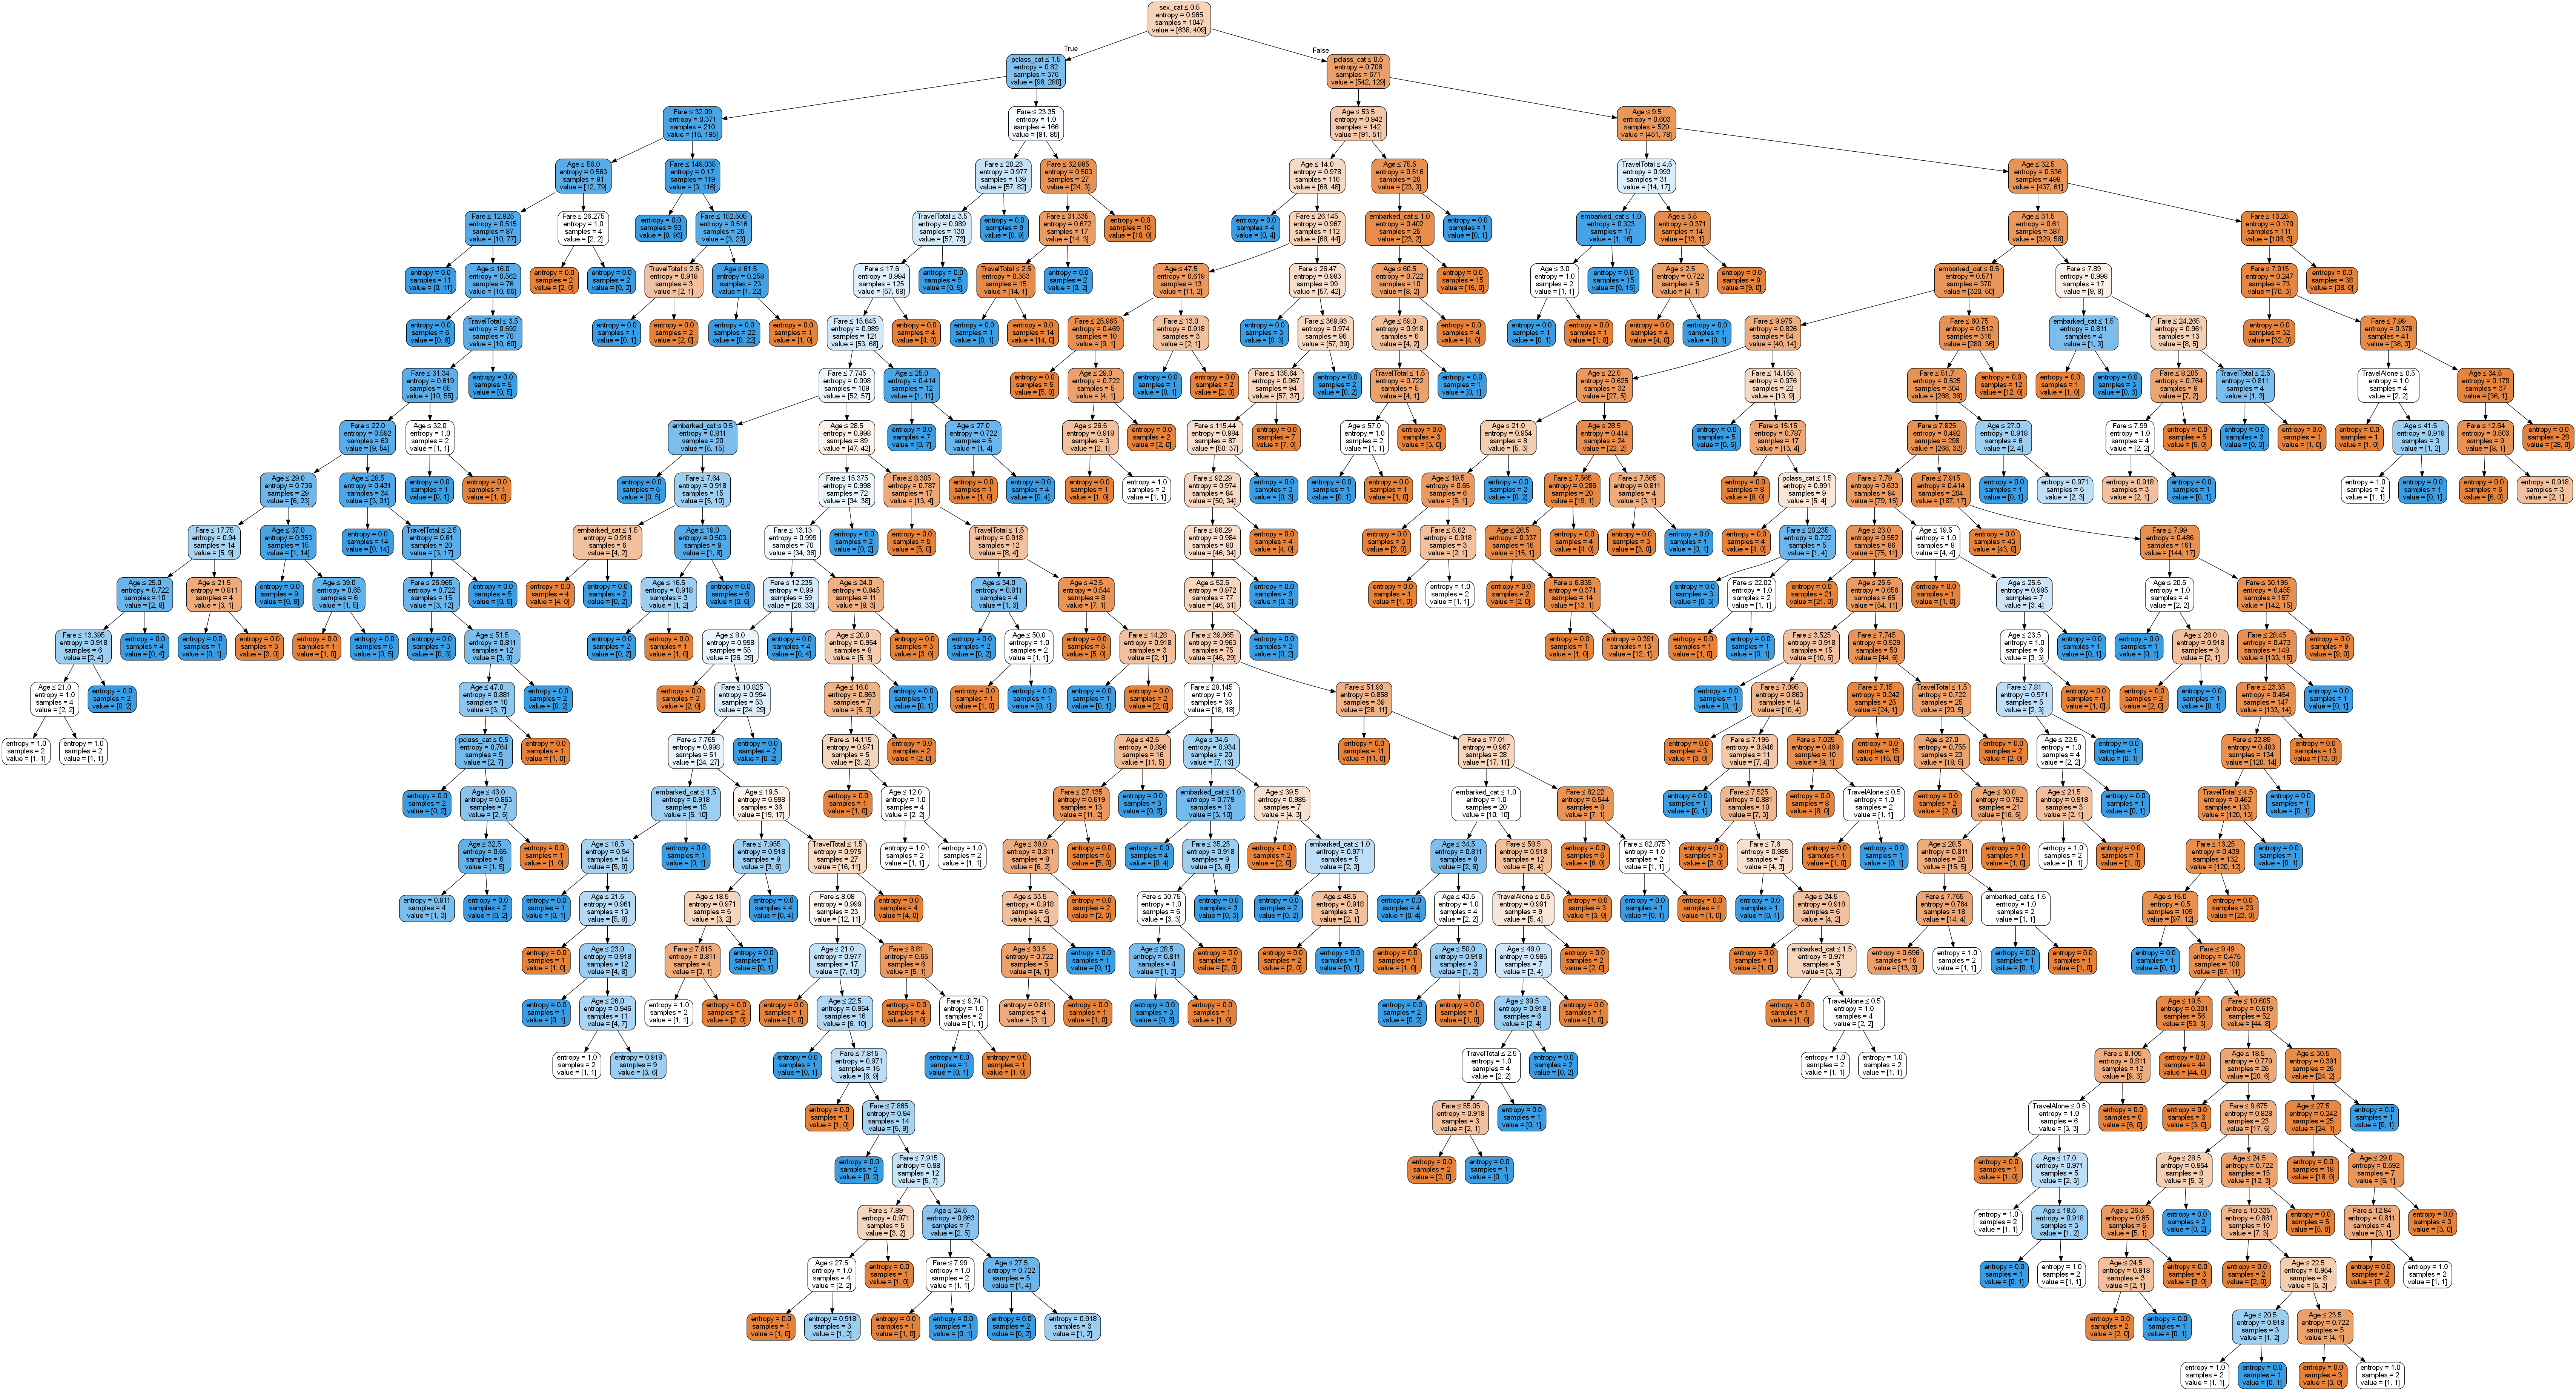

In [19]:
#DT1 Graph
names = ['pclass_cat','sex_cat','Age','Fare','embarked_cat','TravelAlone','TravelTotal']
visualize_tree(tree,names)

In [20]:
print(tree.feature_importances_)

[0.09840041 0.24638448 0.25120078 0.30599897 0.03512863 0.00691312
 0.05597361]


In [21]:
high_importance = ['sex_cat','Age','Fare']
X_train2 = X_train[high_importance]
X_test2 = X_test[high_importance]

In [22]:
#DT2 - Top 3 features only
#Initialize + fit model
tree2 = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, random_state=5).fit(X_train2, y_train)

#Predictions 
y_pred2 = tree2.predict(X_test2)

#Accuracy Score
tree_imp_accuracy = accuracy_score(y_test, y_pred2)
print('Decision Tree Accuracy with high importance attributes: {0:.2f}'.format(tree_imp_accuracy))

Decision Tree Accuracy with high importance attributes: 0.71



(process:11132): GLib-GIO-WARNING **: 20:25:35.375: Unexpectedly, UWP app `Microsoft.ZuneMusic_10.20122.11121.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ZuneMusic_8wekyb3d8bbwe!Microsoft.ZuneMusic') supports 20 extensions but has no verbs



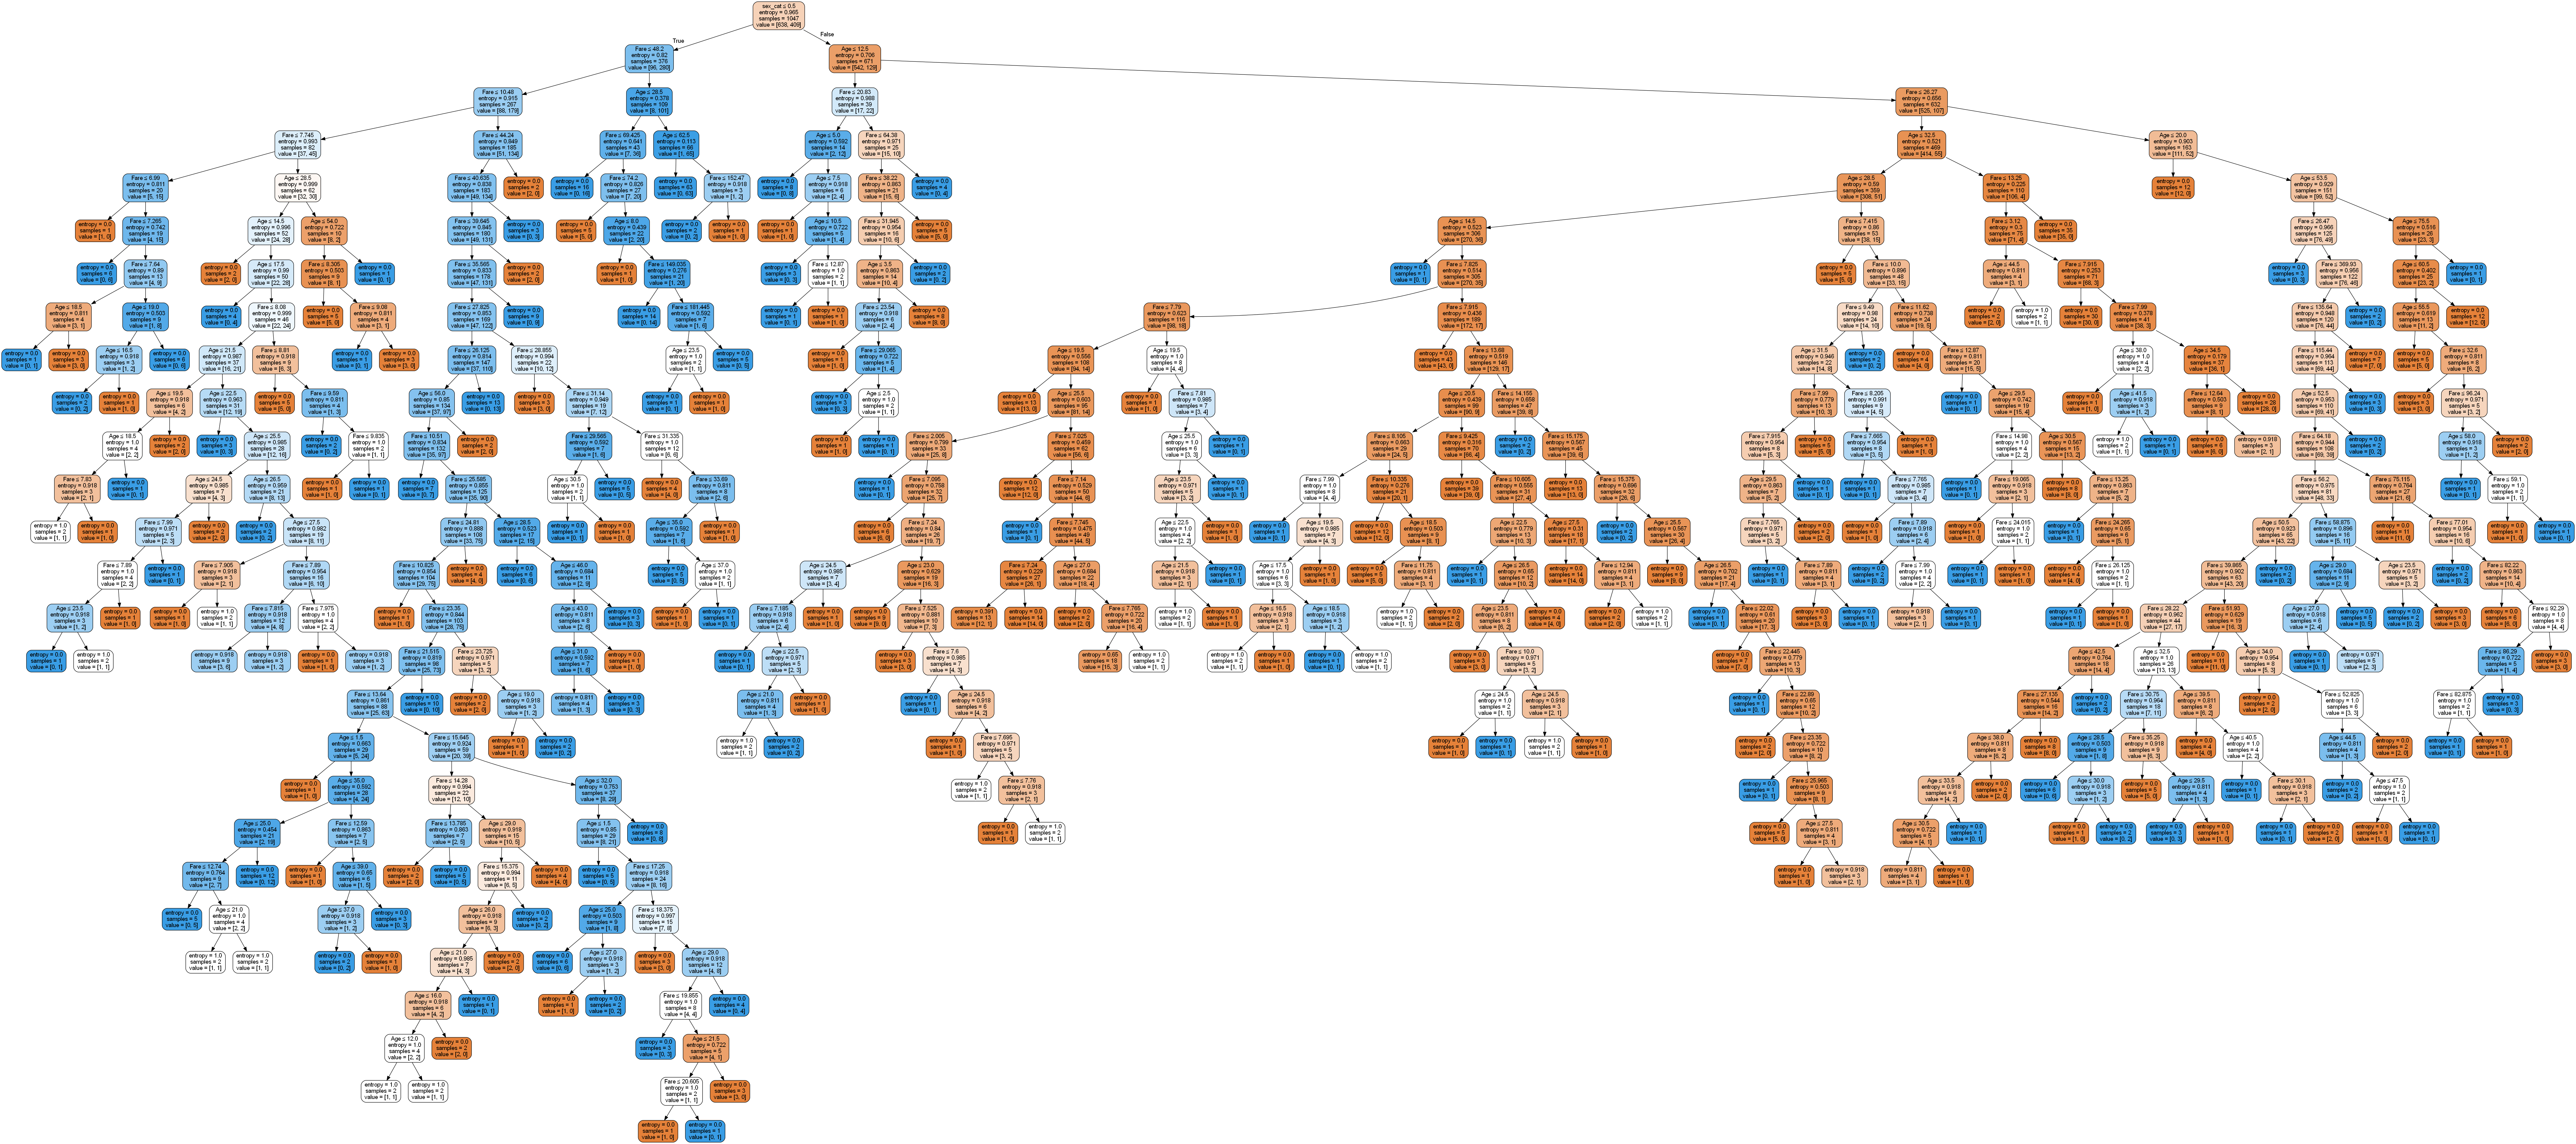

In [23]:
#DT2 Graph
visualize_tree(tree2,high_importance)

### Random Forest

In [24]:
#RF1 - All attributes
#Initalize + fit model
clf = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train, y_train)

#Predictions
y_pred = clf.predict(X_test)

#Accuracy Score
RF_all_accuracy = accuracy_score(y_test,y_pred)
print('Random Forest Accuracy with all attributes: {0:.2f}'.format(RF_all_accuracy))

Random Forest Accuracy with all attributes: 0.77


In [25]:
print(clf.feature_importances_)

[0.07757615 0.26830014 0.26488744 0.2859878  0.03163102 0.01317605
 0.05844141]


In [26]:
#RF2 - Top 3 features only
#Initialize + fit model
clf2 = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train2, y_train)

#Predictions
y_pred2 = clf2.predict(X_test2)

#Accuracy Score
RF_imp_accuracy = accuracy_score(y_test,y_pred2)
print('Random Forest Accuracy with high importance attributes: {0:.2f}'.format(RF_imp_accuracy))

Random Forest Accuracy with high importance attributes: 0.76


## Compare Accuracy Scores


In [27]:
#All Accuracies
print('NB accuracy: {0:.2f}'.format(NB_all_accuracy))

print("Decision Tree:")
print('All attributes: {0:.2f}'.format(tree_all_accuracy))
print('High importance attributes: {0:.2f}'.format(tree_imp_accuracy))

print("Random Forsest:")
print('All attributes: {0:.2f}'.format(RF_all_accuracy))
print('High importance attributes: {0:.2f}'.format(RF_imp_accuracy))

NB accuracy: 0.79
Decision Tree:
All attributes: 0.76
High importance attributes: 0.71
Random Forsest:
All attributes: 0.77
High importance attributes: 0.76
